In [1]:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

In [2]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

In [23]:
from ej1.per_averaging import periodogram_averaging

In [3]:
def read_ligo(filename):
    f = h5py.File(filename, 'r')
    strain = f['strain/Strain'][...]
    fs = 1/ f['strain/Strain'].attrs['Xspacing']
    start_time = f['meta/GPSstart'][()]
    f.close()
    return strain, start_time, fs

In [4]:
# Open hdf5 files
h1_s, h1_st, h1_fs = read_ligo('../assets/data/h1_32sec_4khz.hdf5')
l1_s, l1_st, l1_fs = read_ligo('../assets/data/l1_32sec_4khz.hdf5')

In [16]:
strain_L1 = l1_s
strain_H1 = h1_s
time = np.arange(len(l1_s)) / 4096 + h1_st
time_H1 = time_L1 = time
dt = 1/h1_fs
fs = int(1/dt)

In [26]:
# Get silence (noise)
event_start = 1126259462
h1_silence = h1_s[(time > event_start + 2)]
l1_silence = l1_s[(time > event_start + 2)]
time_silence = time[(time > event_start + 2)]

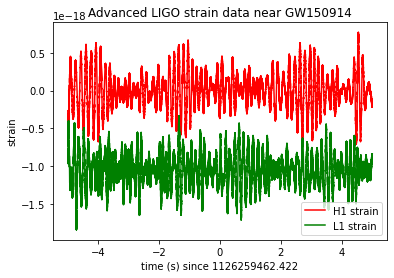

In [29]:
# plot +- 5 seconds around the event:
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 5.                     # seconds around the event
# index into the strain time series for this time interval:
indxt = np.where((time_H1 >= tevent-deltat) & (time_H1 < tevent+deltat))

plt.figure()
plt.plot(time_H1[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
plt.plot(time_L1[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('strain')
plt.legend(loc='lower right')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_strain.png')

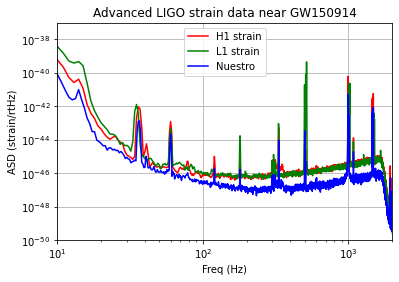

In [35]:
# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000
Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

# We will use interpolations of the ASDs computed above for whitening:
psd_H1 = interp1d(freqs, Pxx_H1)
psd_L1 = interp1d(freqs, Pxx_L1)

# plot the ASDs:
plt.figure()
plt.loglog(freqs, Pxx_H1,'r',label='H1 strain')
plt.loglog(freqs, Pxx_L1,'g',label='L1 strain')
plt.loglog(l1_pa_f*4096, h1_pa_best, 'b', label='Nuestro')
plt.axis([fmin, fmax, 1e-50, 1e-37])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_ASDs.png')

In [33]:
%%time
# Best PA model parameters
k = 16              # 16 Segments
N = int(12*h1_fs)    # 12 secs
overlap = 0.5  #0.5

D = N // k
L = int(D / (1-overlap))
h1_pa_f, h1_pa_best = periodogram_averaging(h1_silence[:N]-np.mean(h1_silence), k, L)
l1_pa_f, l1_pa_best = periodogram_averaging(l1_silence[:N], k, L)

Wall time: 13 ms


In [36]:
psd_L1_2 = interp1d(l1_pa_f*4096, l1_pa_best)

In [38]:
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [41]:
# now whiten the data from H1 and L1, and also the NR template:
strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
strain_L1_whiten = whiten(strain_L1,psd_L1_2,dt)

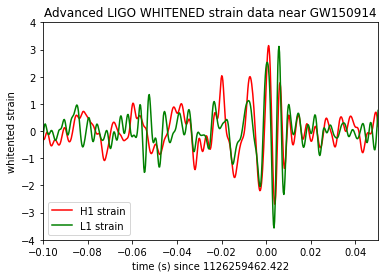

In [44]:
# We need to suppress the high frequencies with some bandpassing:
bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten)
strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten)

# plot the data after whitening:
# first, shift L1 by 7 ms, and invert. See the GW150914 detection paper for why!
strain_L1_shift = -np.roll(strain_L1_whitenbp,int(0.007*fs))

plt.figure()
plt.plot(time-tevent,strain_H1_whitenbp,'r',label='H1 strain')
plt.plot(time-tevent,strain_L1_shift,'g',label='L1 strain')
plt.xlim([-0.1,0.05])
plt.ylim([-4,4])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('Advanced LIGO WHITENED strain data near GW150914')
plt.savefig('GW150914_strain_whitened.png')

In [47]:
np.argmax(strain_L1_shift)

37